In [1]:
import matplotlib.pyplot as plt
import scipy.signal
import numpy as np
import threading
import pyglet
import time
import usb
import sys

%matplotlib inline

In [2]:
VENDOR_ID     = 0x1234   #: Vendor Id
PRODUCT_ID    = 0x0000   #: Product Id for the bridged usb cable
INTERFACE_ID  = 0x81     #: The interface we use to talk to the device
PACKET_LENGTH = 0x40     #: 64 bytes

class Nia():
    """ Attaches the NIA device, and provides low level data collection
    """ 

    def __init__(self, seconds=1) :
        self.read_length = 1024
        self.incoming_data = np.zeros(self.read_length*2, dtype=np.uint32)
        self.current_data = np.zeros(4096, dtype=np.uint32)
        self.long_data = np.zeros(seconds*4096, dtype=np.uint32)      

        self.device = usb.core.find(idVendor=VENDOR_ID, idProduct=PRODUCT_ID)
        self.device.reset()
    
    def _bulk_read(self):
        """ Read data off the NIA from its internal buffer, of up to 16 samples"""
        read_bytes = self.device.read(INTERFACE_ID, PACKET_LENGTH, timeout=30)
        return read_bytes
        
    def _get_data(self):
        """ This function is called via threading, so that we can do data processing 
        while collecting new data. It collects ~250ms of EEG data, and updates an 
        array of the last seconds worth of data (~4096 samples)"""

        count = 0
        while True:
            bytes_data = self._bulk_read()
            point_count = int(bytes_data[54])
            
            for i in range(point_count):
                self.incoming_data[count + i] = int.from_bytes(bytes_data[i*3:i*3+3], byteorder='little')
               
            count = count + point_count

            if count >= self.read_length:
                break
        self.current_data[:-count] = self.current_data[count:]
        self.current_data[-count:] = self.incoming_data[:count]
        
    def update(self):
        data_thread = threading.Thread(target=self._get_data)
        data_thread.start()
        data_thread.join()
        
    def _get_long_data(self):
        """ This function is called via threading, so that we can do data processing 
        while collecting new data. It collects ~250ms of EEG data, and updates an 
        array of the last seconds worth of data (~4096 samples)"""

        count = 0
        while True:
            bytes_data = self._bulk_read()
            point_count = int(bytes_data[54])
            
            for i in range(point_count):
                try:
                    self.long_data[count + i] = int.from_bytes(bytes_data[i*3:i*3+3], byteorder='little')
                except:
                    break
            count = count + point_count

            if count >= len(self.long_data):
                break
        
    def update_long_data(self):
        data_thread = threading.Thread(target=self._get_long_data)
        data_thread.start()
        data_thread.join()    
        
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = scipy.signal.butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = scipy.signal.sosfilt(sos, data)
        return y

In [3]:
# instantiate our NIA class
if 'nia' in locals():
    nia.device.reset()
nia = Nia()

Text(0.5, 1.0, 'Raw EEG data - 1 second')

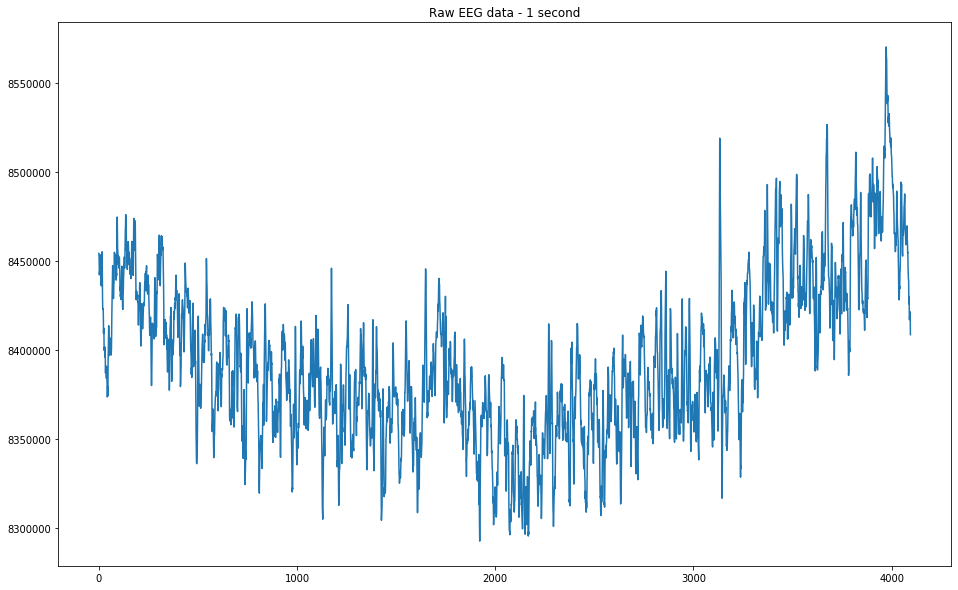

In [4]:
# Capture a seconds worth of EEG Data (each update captures ~250 ms of data)

for i in range(4):
    nia.update()

plt.figure(figsize=(16,10))
plt.plot(nia.current_data)
plt.title('Raw EEG data - 1 second')


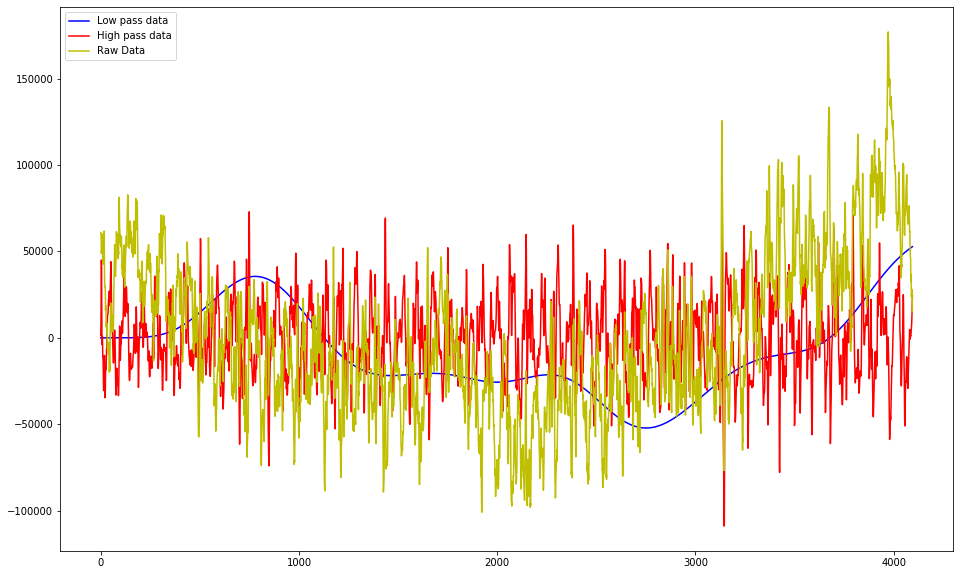

In [5]:
# Plot the Raw data, and the frequencies to be filtered out

plt.figure(figsize=(16,10))
filtered = butter_bandpass_filter(nia.current_data - np.mean(nia.current_data), lowcut=0.0001, highcut=5, fs=4096, order=6)
plt.plot(filtered, c='b', label='Low pass data')

filtered = butter_bandpass_filter(nia.current_data - np.mean(nia.current_data), lowcut=40, highcut=1000, fs=4096, order=6)
plt.plot(filtered, c='r', label='High pass data')

plt.plot(nia.current_data- np.mean(nia.current_data), c='y', label='Raw Data')
plt.legend()

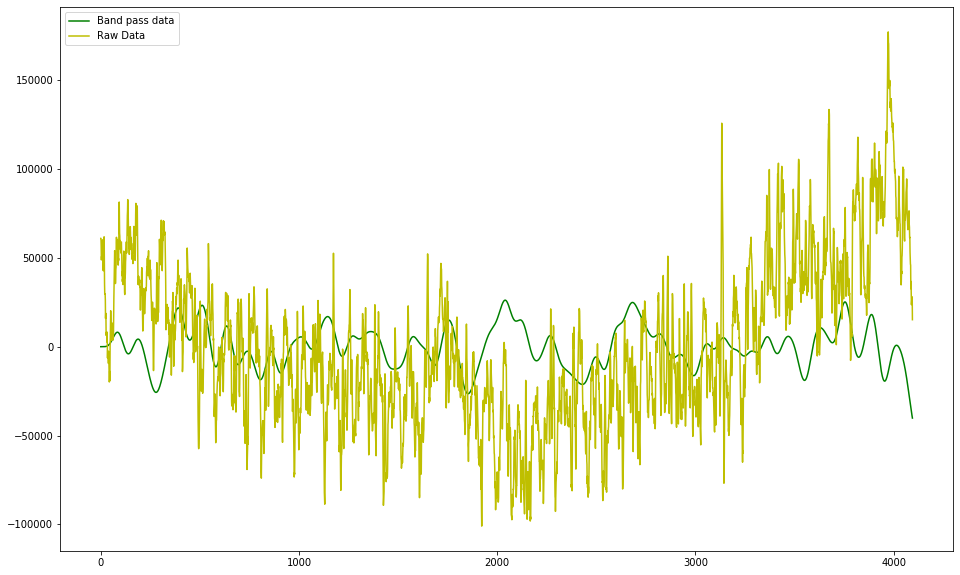

In [6]:
# Plot the Raw data, and the results from the band pass filter

plt.figure(figsize=(16,10))

filtered = butter_bandpass_filter(nia.current_data - np.mean(nia.current_data), lowcut=5, highcut=35, fs=4096, order=6)
plt.plot(filtered, c='g', label='Band pass data')


plt.plot(nia.current_data- np.mean(nia.current_data), c='y', label='Raw Data')
plt.legend()

/home/dnhkng/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/dnhkng/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-20000000.0, 20000000.0)

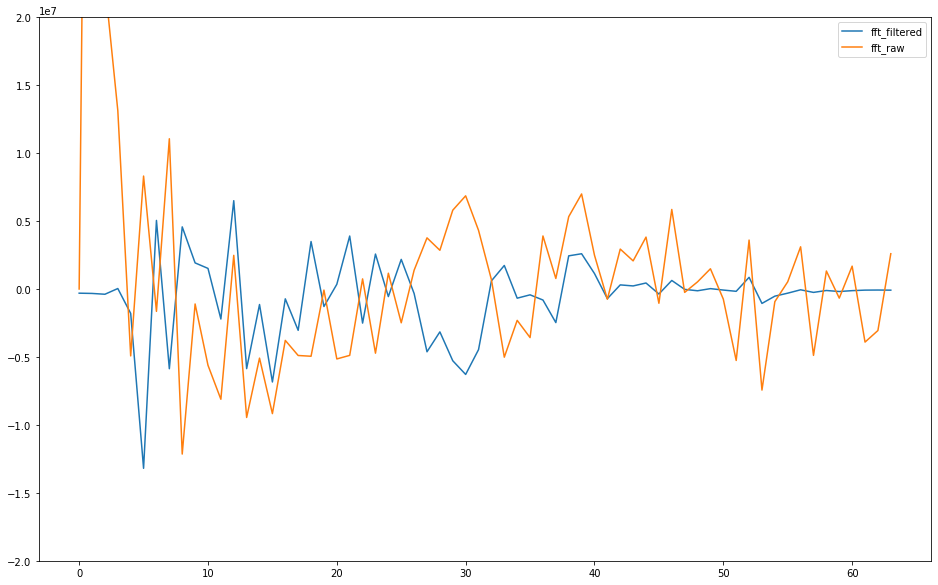

In [7]:
# Plot the Fourier transform of the raw and band pass filtered data

filtered = butter_bandpass_filter(nia.current_data - np.mean(nia.current_data), lowcut=5, highcut=35, fs=4096, order=6)

fft_filtered = np.fft.fftn(filtered)
fft_raw = np.fft.fftn(nia.current_data - np.mean(nia.current_data))

plt.figure(figsize=(16,10))
plt.plot(fft_filtered[:64], label='fft_filtered')
plt.plot(fft_raw[:64], label='fft_raw')
plt.legend()
plt.ylim(-2e7,2e7)

In [8]:
# Capture some brain wave activity while relaxed
time.sleep(3)

for i in range(4):
    nia.update()

relaxed_filtered = butter_bandpass_filter(nia.current_data - np.mean(nia.current_data), lowcut=5, highcut=40, fs=4096, order=4)

In [9]:
# Capture some brain wave activity while concentrating
time.sleep(3)

for i in range(4):
    nia.update()

concentrating_filtered = butter_bandpass_filter(nia.current_data - np.mean(nia.current_data), lowcut=5, highcut=40, fs=4096, order=4)

Text(0.5, 0, 'milliseconds')

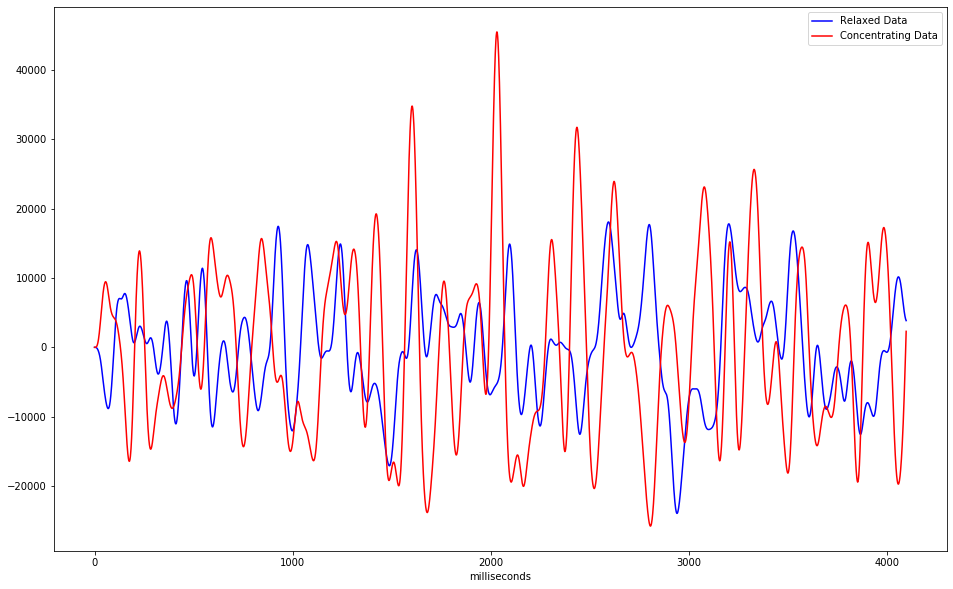

In [10]:
# Plot relaxed vs concentrating filtered data    
plt.figure(figsize=(16,10))
plt.plot(relaxed_filtered, c='b', label='Relaxed Data')
plt.plot(concentrating_filtered, c='r', label='Concentrating Data')
plt.legend()
plt.xlabel('milliseconds')

# Capture lots of data for training the Autoencoder
In 5 minute batches of training data

In [11]:
# instantiate our NIA class
if 'nia' in locals():
    nia.device.reset()
nia = Nia(300)

In [12]:
# save some data
nia.update_long_data()
np.save('5m_1.npy', nia.long_data)

In [13]:
nia.update_long_data()
np.save('5m_2.npy', nia.long_data)

In [14]:
nia.update_long_data()
np.save('5m_3.npy', nia.long_data)

In [15]:
nia.update_long_data()
np.save('5m_4.npy', nia.long_data)

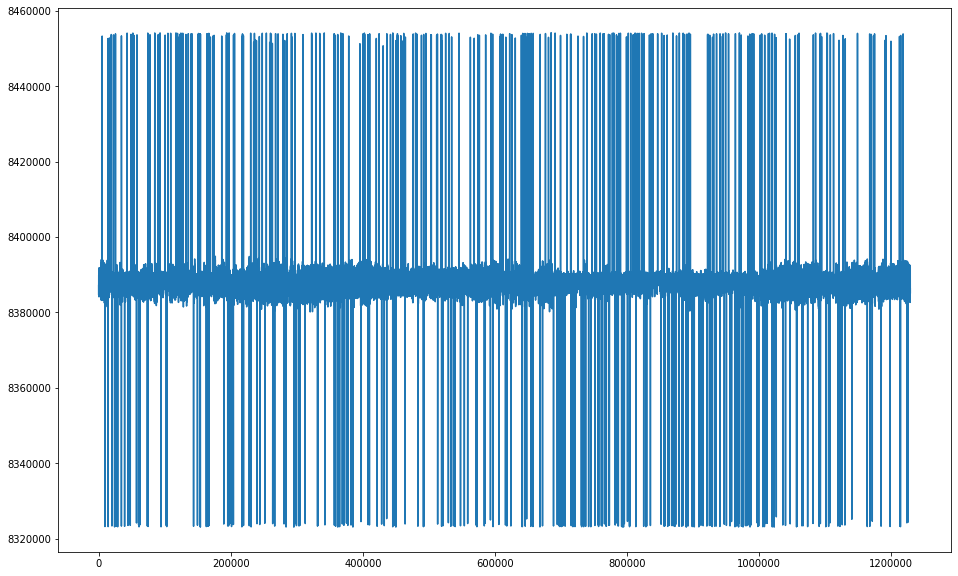

In [16]:
plt.figure(figsize=(16,10))
plt.plot(nia.long_data)

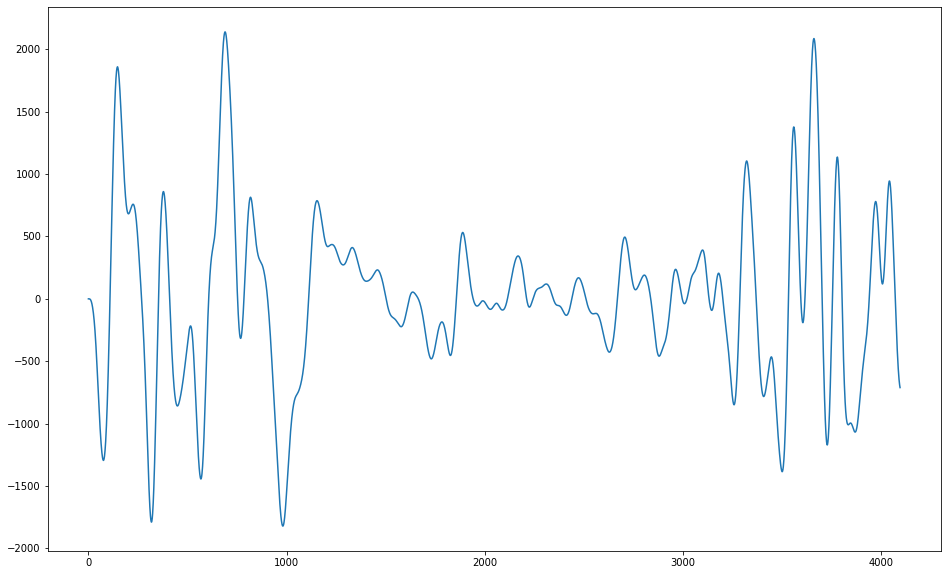

In [17]:
long_filtered = butter_bandpass_filter(nia.long_data - np.mean(nia.long_data), lowcut=5, highcut=40, fs=4096, order=4)
plt.figure(figsize=(16,10))
plt.plot(long_filtered[:4096])